In [1]:
import os

import matplotlib.pyplot as plt
import torch
from torch.utils.data import  DataLoader
from torch.autograd.variable import Variable
import torchvision.utils as vutils
import torch.optim as optim
import torch.autograd as autograd
from AADB.AADB import AADB_binaries, AADB_classes
from TheSUN.SUN import SUN
# from models.ACGAN import Generator, Discriminator
# from models.cGAN import Generator, Discriminator
from models.CTWGAN import Generator, Discriminator
from utils.utils import *
from models.ResNet18 import RegressionNetwork
import torch.nn as nn

import torchvision.transforms as T
from PIL import Image

from torchvision import transforms, datasets
from torch.utils.data import DataLoader

### Variables

In [2]:
epochs = 1000
batch_size = 64
gamma = 0.0003
b1 = 0.9
b2 = 0.999
n_critic = 5
lambda_1 = 10
lambda_2 = 2
m = 0.2
image_size = 64
latent_dim = 128
channels = 3
sample_interval = 256
is_load = False

#### AADB

In [3]:
image_dir = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\ImageAesthetics_ECCV2016\datasetImages_warp256'
label_csv_path = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\\'
samples_path = "F:\Projects\Disertatie\ImageAestheticsGANs\cGAN_64x64"
os.makedirs(samples_path, exist_ok=True)

ckpt_path = ''  # to set if checkpoint

In [4]:
aadb = AADB_binaries(image_dir, label_csv_path)
aadb_test = AADB_binaries(image_dir, label_csv_path, test=True)
n_classes = AADB_binaries.get_classes()
n_classes

8

tensor([0, 0, 0, 0, 0, 0, 0, 1])


8958

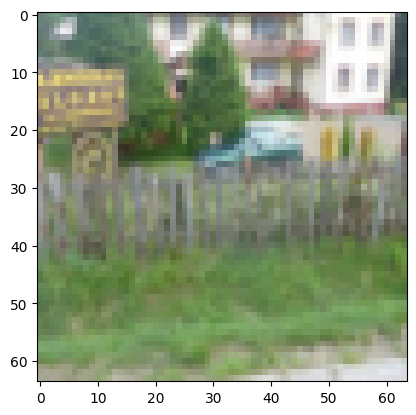

In [5]:
show_example(*aadb[0])
len(aadb)

tensor([0, 1, 1, 1, 0, 1, 1, 0])


1000

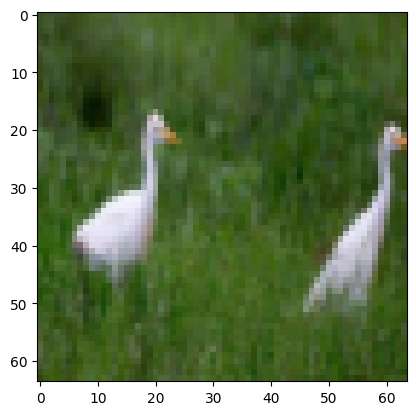

In [6]:
show_example(*aadb_test[0])
len(aadb_test)

In [7]:
aadb = aadb + aadb_test

#### Dataloaders

In [8]:
train_dl = DataLoader(aadb, batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

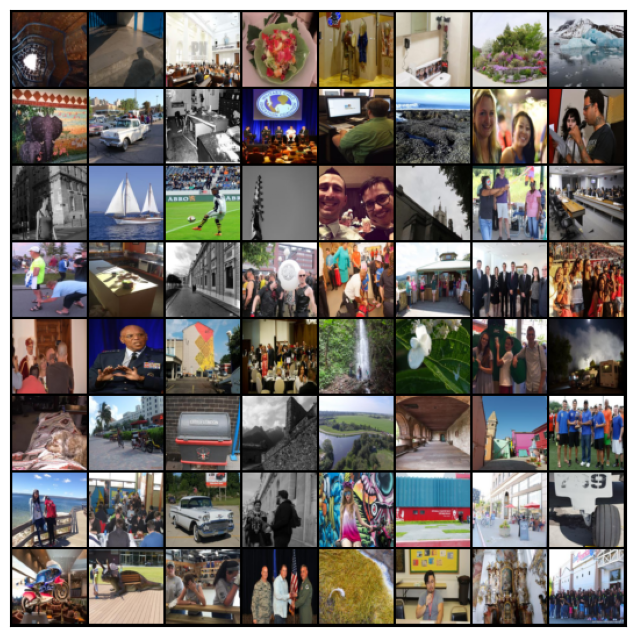

In [9]:
show_batch(train_dl)

In [10]:
for image, labels in train_dl:
    print(image.shape)
    print(type(labels))
    print(labels.shape)
    break

torch.Size([64, 3, 64, 64])
<class 'torch.Tensor'>
torch.Size([64, 8])


In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


#### Sample Noise

In [12]:
cuda = torch.cuda.is_available()

In [13]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [14]:
noise_fixed = Variable(Tensor(25, latent_dim, 1, 1).normal_(0, 1), requires_grad=False)

In [15]:
noise_fixed.shape

torch.Size([25, 128, 1, 1])

In [16]:
noise_labels = Variable(torch.randint(2, (25, n_classes, 1, 1)), requires_grad= False)

In [17]:
noise_labels.shape

torch.Size([25, 8, 1, 1])

#### Model and Loss

In [15]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [16]:
def save_diagram_loss(list_1, list_2,
                 label1="D", label2="G",
                 title="Generator and Discriminator loss During Training",
                 x_label="iterations", y_label="Loss",
                 path=samples_path,
                 name='loss.jpg'
                 ):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(list_1, label=label1)
    plt.plot(list_2, label=label2)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.savefig(os.path.join(path, name))
    plt.close()

In [17]:
optimizer_D = optim.Adam(discriminator.parameters(), lr=gamma, betas=(b1, b2))
optimizer_G = optim.Adam(generator.parameters(), lr=gamma, betas=(b1, b2))

In [18]:
def load_cifar10(img_size):
    compose = transforms.Compose(
        [transforms.Resize(img_size),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
         ])
    output_dir = './data/cifar10'
    cifar = datasets.CIFAR10(root=output_dir, download=True, train=True,
                             transform=compose)
    return cifar

In [19]:
cifar = load_cifar10(image_size)
train_dl = DataLoader(cifar, shuffle=True, batch_size=batch_size) # List, NCHW format.

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


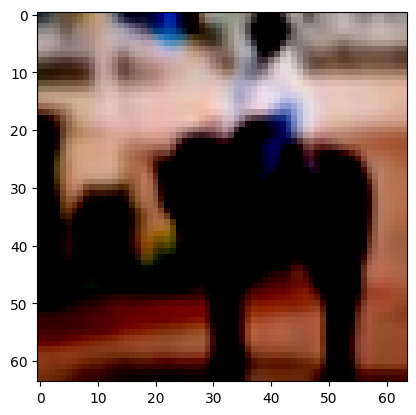

In [25]:
show_example(*cifar[11])

## Train

In [26]:
if is_load:
    print("Loading checkpoint...")

    checkpoint = torch.load(ckpt_path)
    last_epoch = checkpoint['epoch']
    iteration = checkpoint['iteration']
    last_i = checkpoint['last_current_iteration']
    noise_fixed = checkpoint['noise_fixed']

    list_loss_D = checkpoint['list_loss_D']
    list_loss_G = checkpoint['list_loss_G']

    loss_D = list_loss_D[-1]
    loss_G = list_loss_G[-1]

    discriminator.load_state_dict(checkpoint['netD_state_dict'])
    generator.load_state_dict(checkpoint['netG_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    discriminator.eval()
    generator.eval()

else:
    last_epoch = 0
    iteration = 0

    list_loss_G = []
    list_loss_D = []

for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for i, (batch, _) in enumerate(train_dl):
        for iter in range(n_critic):
            x = Variable(batch.type(Tensor))
            noise = Variable(Tensor(batch.size(0), latent_dim, 1, 1).normal_(0, 1))
            x_tilde = Variable(generator(noise), requires_grad=True)

            epsilon = Variable(Tensor(batch.size(0), 1, 1, 1).uniform_(0, 1))

            x_hat = epsilon*x + (1 - epsilon)*x_tilde
            x_hat = torch.autograd.Variable(x_hat, requires_grad=True)

            # Put the interpolated data through critic.
            dw_x = discriminator(x_hat)
            grad_x = torch.autograd.grad(outputs=dw_x, inputs=x_hat,
                                         grad_outputs=Variable(Tensor(batch.size(0), 1, 1, 1).fill_(1.0), requires_grad=False),
                                         create_graph=True, retain_graph=True, only_inputs=True)
            grad_x = grad_x[0].view(batch.size(0), -1)
            grad_x = grad_x.norm(p=2, dim=1)

            # Update critic.
            optimizer_D.zero_grad()

            # Standard WGAN loss.
            d_wgan_loss = torch.mean(discriminator(x_tilde)) - torch.mean(discriminator(x))

            # WGAN-GP loss.
            d_wgp_loss = torch.mean((grad_x - 1)**2)

            ###### Consistency term. ######
            dw_x1, dw_x1_i = discriminator(x, dropout=0.5, intermediate_output=True) # Perturb the input by applying dropout to hidden layers.
            dw_x2, dw_x2_i = discriminator(x, dropout=0.5, intermediate_output=True)

            # Using l2 norm as the distance metric d, referring to the official code (paper ambiguous on d).
            second_to_last_reg = ((dw_x1_i-dw_x2_i) ** 2).mean(dim=1).unsqueeze_(1).unsqueeze_(2).unsqueeze_(3)
            d_wct_loss = (dw_x1-dw_x2) ** 2 \
                         + 0.1 * second_to_last_reg \
                         - m
            d_wct_loss, _ = torch.max(d_wct_loss, 0) # torch.max returns max, and the index of max

            # Combined loss.
            loss_D = d_wgan_loss + lambda_1*d_wgp_loss + lambda_2*d_wct_loss

            loss_D.backward()
            optimizer_D.step()

         # == Generator update == #
        noise = Variable(Tensor(batch.size(0), latent_dim, 1, 1).normal_(0, 1))
        imgs_fake = generator(noise)

        optimizer_G.zero_grad()

        loss_G = -torch.mean(discriminator(imgs_fake))

        loss_G.backward()
        optimizer_G.step()

        with torch.no_grad():
            list_loss_D.append(loss_D.item())

            if type(loss_G) == float:
                list_loss_G.append(loss_G)
            else:
                list_loss_G.append(loss_G.item())

            if i % 100 == 0: # batches
                print(
                    '[%d/%d][%2d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                    % (epoch, epochs, i, len(train_dl),
                       list_loss_D[-1], list_loss_G[-1]))

            if (iteration % 500 == 0) or ((epoch == epochs - 1) and (i == len(train_dl) - 1)):
                samples = generator(noise_fixed).cpu()
                vutils.save_image(samples, os.path.join(samples_path, '%d.jpg' % iteration), padding=2, normalize=True)
                save_diagram_loss(list_loss_D, list_loss_G, name='loss.jpg')

            # Save model after 5000 iterations
            if (iteration % 5000 == 0) or ((epoch == epochs - 1) and (i == len(train_dl) - 1)):
                save_path = os.path.join(samples_path, 'checkpoint_iteration_%d.tar' % iteration)
                torch.save({
                    'epoch': epoch,
                    'iteration': iteration,
                    'last_current_iteration': i,
                    'netD_state_dict': discriminator.state_dict(),
                    'netG_state_dict': generator.state_dict(),
                    'optimizer_D_state_dict': optimizer_D.state_dict(),
                    'optimizer_G_state_dict': optimizer_G.state_dict(),
                    'list_loss_D': list_loss_D,
                    'list_loss_G': list_loss_G,
                    'noise_fixed': noise_fixed
                }, save_path)

        # iteration: total iteration, i: iteration of current epoch
        iteration += 1
        is_load = False

Epoch 0
[0/1000][ 0/782]	Loss_D: 7.2546	Loss_G: 2.9719
[0/1000][100/782]	Loss_D: -55.0811	Loss_G: 97.9760
[0/1000][200/782]	Loss_D: -33.4032	Loss_G: 121.3923
[0/1000][300/782]	Loss_D: -32.2573	Loss_G: 134.0665
[0/1000][400/782]	Loss_D: -23.4496	Loss_G: 144.2388
[0/1000][500/782]	Loss_D: -25.2166	Loss_G: 181.9955
[0/1000][600/782]	Loss_D: -17.3439	Loss_G: 166.3222
[0/1000][700/782]	Loss_D: -20.1112	Loss_G: 218.6874
Epoch 1
[1/1000][ 0/782]	Loss_D: -18.0105	Loss_G: 158.2411
[1/1000][100/782]	Loss_D: -10.5962	Loss_G: 158.4591
[1/1000][200/782]	Loss_D: -12.6687	Loss_G: 208.4483
[1/1000][300/782]	Loss_D: -14.4368	Loss_G: 169.0916
[1/1000][400/782]	Loss_D: -6.7770	Loss_G: 178.5717
[1/1000][500/782]	Loss_D: -13.1102	Loss_G: 144.6441
[1/1000][600/782]	Loss_D: -11.1077	Loss_G: 183.7417
[1/1000][700/782]	Loss_D: -10.7485	Loss_G: 203.5121
Epoch 2
[2/1000][ 0/782]	Loss_D: -13.2847	Loss_G: 177.8822
[2/1000][100/782]	Loss_D: -18.5445	Loss_G: 198.7732
[2/1000][200/782]	Loss_D: -8.6117	Loss_G: 201.646


KeyboardInterrupt

